In [1]:
import pandas as pd
import numpy as np
import pyross
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('coronavirus-data-master/trends/data-by-day.csv', parse_dates = ['date_of_interest'])

In [3]:
df['cum_case'] = df['CASE_COUNT'].cumsum()

In [4]:
df['daily_death_rate'] = df['DEATH_COUNT']/df['CASE_COUNT']
df['daily_death_rate'].describe()

count    428.000000
mean       0.035264
std        0.041955
min        0.000000
25%        0.010829
50%        0.019261
75%        0.036931
max        0.244267
Name: daily_death_rate, dtype: float64

In [5]:
df['cum_death'] = df['DEATH_COUNT'].cumsum()
df['death_rate'] = df['cum_death']/df['cum_case']
df['death_rate'].describe()

count    430.000000
mean       0.061241
std        0.024338
min        0.000000
25%        0.040154
50%        0.070053
75%        0.082668
max        0.088175
Name: death_rate, dtype: float64

In [6]:
df['mortality_rate_7d'] = df['cum_death'].div(df['cum_case'].shift(7))
df['mortality_rate_14d'] = df['cum_death'].div(df['cum_case'].shift(14))

In [7]:
df['growth_rate'] = df['CASE_COUNT'].div(df['cum_case'].shift(1))
df['growth_rate'].describe()

count    429.000000
mean       0.041634
std        0.186239
min        0.000000
25%        0.001724
50%        0.003478
75%        0.008136
max        2.500000
Name: growth_rate, dtype: float64

In [8]:
gamma = 1/7
df['Rt'] = (df['growth_rate']/gamma)+1
df['Rt'].describe()

count    429.000000
mean       1.291439
std        1.303672
min        1.000000
25%        1.012067
50%        1.024346
75%        1.056950
max       18.500000
Name: Rt, dtype: float64

In [9]:
M = 1                  # the SIR model has no age structure
Ni = 18804000*np.ones(M)   # so there is only one age group 
N = np.sum(Ni)         # and the total population is the size of this age group

gamma = 1/7           # duration period is 7 days
d = 0.006             # natural death rate is 0.6%
k = 1/2              # incubation period can be 2-14 days
r0 = 1.29

alpha = 0.52              # fraction of asymptomatic infectives 
beta  = 0.2 #r0*(gamma + d) * ((k+d)/k)           # infection rate 



gE    = k + d            # progression rate from E to A
gA    = k + d           # rate to go from A to Ia
gIa   = gamma + d         # removal rate of asymptomatic infectives 
gIs   = gamma + d        # removal rate of symptomatic infectives 
fsa   = 0.3              # Fraction by which symptomatic individuals do not self isolate (not sure)

E0  = np.array([0])
A0  = np.array([1])
Ia0 = np.array([0])     # the SIR model has only one kind of infective 
Is0 = np.array([1])     # we take these to be symptomatic 
Q0  = np.array([0])
R0  = np.array([0])     # and assume there are no removed individuals initially 
S0  = N-(Ia0+Is0+R0+E0)    # The initial susceptibles are obtained from S + E + A + Ia + Is + R = N

# there is no contact structure
def contactMatrix(t):   
    return np.identity(M) 

# duration of simulation and number of datapoints
Tf = 1000;  Nt=Tf+1;

In [10]:

# For the SEAIR model, we set all rates to the Q-class to zero
tE    = 0.00           # rate E  -> Q
tA    = 0.00           # rate A  -> Q
tIa   = 0.00           # rate Ia -> Q
tIs   = 0.00           # rate Is -> Q
#tIs   = 0.05           # rate Is -> Q

# instantiate model
parameters = {'alpha':alpha, 'beta':beta,
              'gE':gE,'gA':gA,
              'gIa':gIa, 'gIs':gIs, 'gE':gE, 'fsa':fsa}
model = pyross.deterministic.SEAIR(parameters, M, Ni)

# simulate model
data=model.simulate(S0, E0, A0, Ia0, Is0, contactMatrix, Tf, Nt)

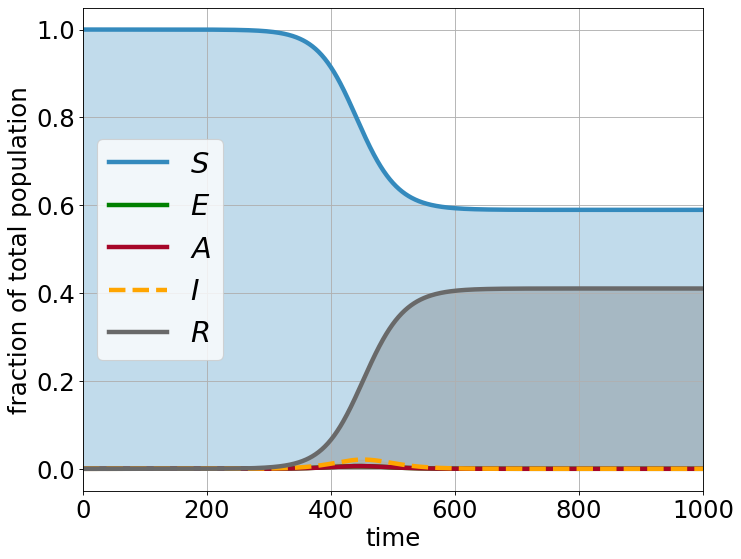

In [11]:

# plot the results of the simulation

S  = data['X'][:,0].flatten()
E  = data['X'][:,1].flatten()
A  = data['X'][:,2].flatten()
Ia = data['X'][:,3].flatten()
Is = data['X'][:,4].flatten()
t = data['t']


fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})


plt.fill_between(t, 0, S/N, color="#348ABD", alpha=0.3)
plt.plot(t, S/N, '-', color="#348ABD", label='$S$', lw=4)

plt.plot(t, E/N, '-', color="green", label='$E$', lw=4)
plt.fill_between(t, 0, E/N, color='green', alpha=0.3)

plt.fill_between(t, 0, A/N, color='#A60628', alpha=0.3)
plt.plot(t, A/N, '-', color='#A60628', label='$A$', lw=4)

plt.fill_between(t, 0, (Ia+Is)/N, color='orange', alpha=0.1)
plt.plot(t, (Ia+Is)/N, '-', color='orange', label='$I$', ls='--',lw=4)

R=N-S-E-A-Ia-Is; plt.fill_between(t, 0, R/N, color="dimgrey", alpha=0.3)
plt.plot(t, R/N, '-', color="dimgrey", label='$R$', lw=4)

plt.legend(fontsize=26); plt.grid() 
plt.xlabel(r'time')
plt.ylabel(r'fraction of total population')
plt.autoscale(enable=True, axis='x', tight=True)

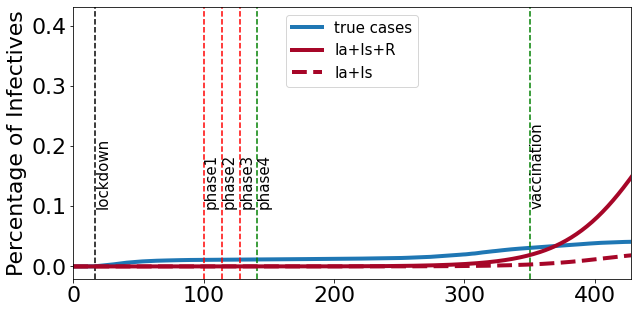

In [12]:
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df['cum_case']/18804000, lw=4,label = 'true cases')
plt.ylabel('Percentage of Infectives')
plt.xticks(np.arange(0, 428, 100))
plt.axvline(x=17,color='k', linestyle='--')
plt.text(17,0.1,'lockdown',rotation=90,fontsize = 15)
plt.axvline(x=100,color='r', linestyle='--')
plt.text(100,0.1,'phase1',rotation=90,fontsize = 15)
plt.axvline(x=114,color='r', linestyle='--')
plt.text(114,0.1,'phase2',rotation=90,fontsize = 15)
plt.axvline(x=128,color='r', linestyle='--')
plt.text(128,0.1,'phase3',rotation=90,fontsize = 15)
plt.axvline(x=141,color='g', linestyle='--')
plt.text(141,0.1,'phase4',rotation=90,fontsize = 15)
plt.axvline(x=350,color='g', linestyle='--')
plt.text(350,0.1,'vaccination',rotation=90,fontsize = 15)
plt.plot((Ia+Is+R)/18804000, '-', color='#A60628', label='Ia+Is+R', lw=4)
plt.plot((Ia+Is)/18804000, '--', color='#A60628', label='Ia+Is', lw=4)
plt.xlim([0, 428])
plt.legend(fontsize=15)
plt.show()

In [13]:
def get_SEAIR(idx0, idx1, E0, A0, Ia0, Is0, S0, gamma=1/7, d=0.006, k=1/2):    
    M = 1                  # the SEAIR model has no age structure
    Ni =18804000*np.ones(M)   # so there is only one age group 
    N = np.sum(Ni)         # and the total population is the size of this age group

    alpha = 0.52            # fraction of asymptomatic infectives 
    
    r0 = df.loc[idx0:idx1, 'Rt'].mean()
    beta = r0*(gamma+d)*((k+d)/k)
    print('inferred beta from real data is:', round(beta,4))

    gE    = k + d           # progression rate from E to A
    gA    = k + d            # rate to go from A to Ia
    gIa   = gamma + d         # removal rate of asymptomatic infectives 
    gIs   = gamma + d        # removal rate of symptomatic infectives 
    fsa   = 0.3             # Fraction by which symptomatic individuals do not self isolate 

    E0  = np.array([E0])
    A0 = np.array([A0])
    Ia0 = np.array([Ia0])     # we take these to be asymptomatic  
    Is0 = np.array([Is0])     # we take these to be symptomatic 
    Q0  = np.array([0])
    S0  = np.array([S0])    # the initial susceptibles are obtained from 
    R0  = N-S0-E0-A0-Ia0-Is0  # removed individuals calculated by equation S + E + A + Ia + Is + R = N
    
    # duration of simulation and data file
    Tf = 430;  Nt=Tf+1;  
    
    def contactMatrix(t):   
        return np.identity(M) 
    
    # For the SEAIR model, we set all rates to the Q-class to zero
    tE    = 0.00           # rate E  -> Q
    tA    = 0.00           # rate A  -> Q
    tIa   = 0.00           # rate Ia -> Q
    tIs   = 0.00           # rate Is -> Q


    # instantiate model
    parameters = {'alpha':alpha, 'beta':beta,
                  'gE':gE,'gA':gA,
                  'gIa':gIa, 'gIs':gIs, 'gE':gE, 'fsa':fsa}
    model = pyross.deterministic.SEAIR(parameters, M, Ni)

    # simulate model
    data = model.simulate(S0, E0, A0, Ia0, Is0, contactMatrix, Tf, Nt)
    
    S_  = list(data['X'][:,0].flatten()[idx0:idx1])
    E_  = list(data['X'][:,1].flatten()[idx0:idx1])
    A_  = list(data['X'][:,2].flatten()[idx0:idx1])
    Ia_ = list(data['X'][:,3].flatten()[idx0:idx1])
    Is_ = list(data['X'][:,4].flatten()[idx0:idx1])
    t_ = data['t']
    
    return S_,E_, A_, Ia_, Is_, t_

In [14]:
final_Ia = []
final_Is = []
final_A = []
final_R = []

lockdown_buffer=30
vaccination_buffer=30
date=[17,17+lockdown_buffer,246,350+vaccination_buffer]
c = [[],[17],[17,17+lockdown_buffer,246,350+vaccination_buffer]]

In [15]:
for idx in c:
    idxs=[0]+idx+[431]
    S=[]
    E=[]
    A=[]
    Ia = []
    Is = []
    pop = 18804000
    E0 = 0
    A0 = 0
    Ia0 = 0
    Is0 = 1
    S0 = pop-1
    for i in range(len(idxs)-1):
        idx0 = idxs[i]
        idx1 = idxs[i+1]
        s, e, a, ia_, is_, t = get_SEAIR(idx0, idx1, E0, A0, Ia0, Is0, S0)
        S+=s
        E+=e
        A+=a
        Ia += ia_
        Is += is_
        E0 = E[-1]
        A0 = A[-1]
        Ia0 = Ia[-1]
        Is0 = Is[-1]
        S0 = S[-1]
        
    S=np.array(S)
    E=np.array(E)
    A = np.array(A)
    Ia=np.array(Ia)
    Is = np.array(Is)
    R = pop - S - E - A - Ia - Is

    final_A.append(A)
    final_Ia.append(Ia)
    final_Is.append(Is)
    final_R.append(R)
    print('\n')

inferred beta from real data is: 0.1945


inferred beta from real data is: 0.9558
inferred beta from real data is: 0.1643


inferred beta from real data is: 0.9558
inferred beta from real data is: 0.2745
inferred beta from real data is: 0.1541
inferred beta from real data is: 0.1581
inferred beta from real data is: 0.1538




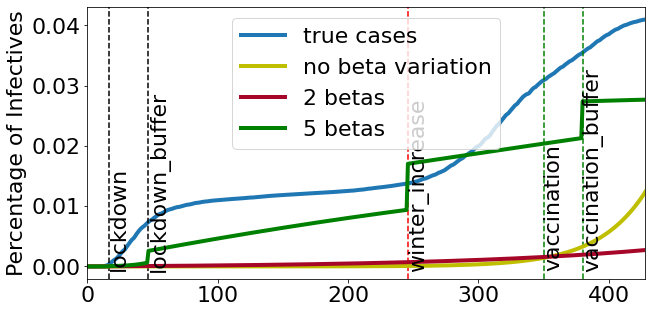

In [16]:
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df['cum_case']/pop, lw=4,label = 'true cases')
plt.ylabel('Percentage of Infectives')
plt.xticks(np.arange(0, 428, 100))
plt.axvline(x=date[0],color='k', linestyle='--')
plt.text(date[0],0,'lockdown',rotation=90)
plt.axvline(x=date[1],color='k', linestyle='--')
plt.text(date[1],0,'lockdown_buffer',rotation=90)
plt.axvline(x=date[2],color='r', linestyle='--')
plt.text(date[2],0,'winter_increase',rotation=90)
plt.axvline(x=350,color='g', linestyle='--')
plt.text(350,0,'vaccination',rotation=90)
plt.axvline(x=date[3],color='g', linestyle='--')
plt.text(date[3],0,'vaccination_buffer',rotation=90)

plt.plot((final_Ia[0]+final_Is[0] + final_R[0])/pop, '-', color='y', label='no beta variation', lw=4) #no variation in beta
plt.plot((final_Ia[1]+final_Is[1] + final_R[1])/pop, '-', color='#A60628', label='2 betas', lw=4) # 2 beta
plt.plot((final_Ia[2]+final_Is[2] + final_R[2])/pop, '-', color='g', label='5 betas', lw=4) # 5 beta

#plt.ylim([0, 0.4])
plt.xlim([0, 428])
plt.legend(loc='upper center')
plt.show()